# A logistic regressor from scratch, with 3 layers

In [47]:
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

## Define the ReLU, sigmoid, binary cross entropy loss functions

In [48]:
def relu(x):
    return np.maximum(0,x)

def sigmoid(z):
    return 1/(1+np.exp(-z))

def avg_log_loss(y_pred,y):
    epsilon = 1e-15
    y_pred_stable = np.clip(y_pred, epsilon, 1 - epsilon)
    cost = -np.sum(np.log(y_pred_stable)*y + np.log(1-y_pred_stable)*(1-y))/y_pred.shape[1]
    return np.squeeze(cost)


## Define the gradients of the functions, this is required for backpropogation

In [49]:
def relu_backward(dA, Z):
    dZ = dA*(Z>0)
    return dZ

def sigmoid_backward(dA, Z):
    "dA is the gradient of the next layer, we want the overall derivative, so compute via chain rule"
    s = sigmoid(Z)
    dAdZ = s*(1-s)
    return dAdZ*dA

In [50]:
def leaky_relu(Z):
    # np.maximum finds the element-wise max
    return np.maximum(0.01 * Z, Z)

def leaky_relu_backward(dA, Z):
    dZ = dA * (Z > 0) + dA * (Z <= 0) * 0.01
    return dZ

## Define our model. We will have 1 input layer, 2 hidden layers and 1 output layer

In [ ]:
class MLP:
    def __init__(self, X_train, Y_train):
        self.X = X_train
        self.Y = Y_train
        self.m = X_train.shape[1]

    def model(self,i,l1,l2,o):
        self.W1 = np.random.randn(l1, i) * np.sqrt(2 / i)
        self.W2 = np.random.randn(l2, l1) * np.sqrt(2 / l1)
        self.W3 = np.random.randn(o, l2) * np.sqrt(2 / l2)

        self.B1 = np.ones((l1,1)) * 0.01
        self.B2 = np.ones((l2,1)) * 0.01
        self.B3 = np.zeros((o,1))

    def forward(self):
        self.Z1 = np.dot(self.W1,self.X) + self.B1 #linear 1
        self.A1 = leaky_relu(self.Z1) #relu
        self.Z2 = np.dot(self.W2,self.A1) + self.B2 #linear 2
        self.A2 = leaky_relu(self.Z2) #relu
        self.Z3 = np.dot(self.W3,self.A2) + self.B3 #linear 3
        self.output = sigmoid(self.Z3) #sigmoid

        return self.output

    def backward(self):
        
        self.dZ3 = self.output - self.Y #dJdS
        self.dW3 = np.dot(self.dZ3, self.A2.T)/self.m #dJdS, relu output
        self.dB3 = np.sum(self.dZ3, axis=1, keepdims=True)/self.m 
        self.dA2 = np.dot(self.W3.T, self.dZ3) #linear gradient, dJdS
        self.dZ2 = leaky_relu_backward(self.dA2,self.Z2) #relubackwards with dA, linear 2 output
        self.dW2 = np.dot(self.dZ2, self.A1.T)/self.m
        self.dB2 = np.sum(self.dZ2, axis=1, keepdims=True)/self.m
        self.dA1 = np.dot(self.W2.T, self.dZ2)
        self.dZ1 = leaky_relu_backward(self.dA1,self.Z1)
        self.dW1 = np.dot(self.dZ1, self.X.T)/self.m
        self.dB1 = np.sum(self.dZ1, axis=1, keepdims=True)/self.m

    def train(self, no_epochs, learning_rate):
        for i in range(no_epochs):
            Y_pred = self.forward()
            cost = avg_log_loss(Y_pred, self.Y)
            self.backward()

            self.W1 -= learning_rate * self.dW1
            self.W2 -= learning_rate * self.dW2
            self.W3 -= learning_rate * self.dW3

            self.B1 -= learning_rate * self.dB1
            self.B2 -= learning_rate * self.dB2
            self.B3 -= learning_rate * self.dB3

            print(f"Epoch {i}: cost {cost}")

    def predict(self, X):
        Z1 = np.dot(self.W1,X) + self.B1
        A1 = leaky_relu(Z1)
        Z2 = np.dot(self.W2,A1) + self.B2
        A2 = leaky_relu(Z2)
        Z3 = np.dot(self.W3,A2) + self.B3
        output = sigmoid(Z3)

        return output

    def accuracy(self, X, Y):
        Y_pred = self.predict(X)
        correct = (Y_pred > 0.5) == Y
        print(f"Accuracy: {np.mean(correct)}")

    def plot_decision_boundary(self, X, Y):
    # Set min and max values for the plot
        x_min, x_max = X[0, :].min() - 0.5, X[0, :].max() + 0.5
        y_min, y_max = X[1, :].min() - 0.5, X[1, :].max() + 0.5
        h = 0.01
    
    # Generate a grid of points with 0.01 distance between them
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # "Flatten" the grid so we can feed it to our predict method
    # This creates a (2, N) array, just like our training data
        grid_points = np.c_[xx.ravel(), yy.ravel()].T
    
    # Get predictions for every single point on the grid
    # This is where your new .predict() method is used!
        Z = (self.predict(grid_points) > 0.5)
    
    # Reshape the predictions back into the shape of the grid
        Z = Z.reshape(xx.shape)
    
    # --- Plotting ---
        plt.figure(figsize=(10, 7))
    
    # Plot the "decision regions" (a filled contour plot)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    
    # Plot the original training data on top
    # We use Y[0, :] to get the 1D labels
        plt.scatter(X[0, :], X[1, :], c=Y[0, :], cmap=plt.cm.Spectral)
    
        plt.title("Decision Boundary for the MLP")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.show()

Epoch 0: cost 0.4389805111738777
Epoch 1: cost 0.4116001607222906
Epoch 2: cost 0.39221088137633137
Epoch 3: cost 0.37779254077330426
Epoch 4: cost 0.3666543476725168
Epoch 5: cost 0.3577222309149346
Epoch 6: cost 0.3508247436342567
Epoch 7: cost 0.3452683825648593
Epoch 8: cost 0.3405964785324139
Epoch 9: cost 0.3365204838154459
Epoch 10: cost 0.333019471894345
Epoch 11: cost 0.3299857797511547
Epoch 12: cost 0.32744432248515704
Epoch 13: cost 0.32522878401517546
Epoch 14: cost 0.323261604777632
Epoch 15: cost 0.3214827828363632
Epoch 16: cost 0.3198742531734804
Epoch 17: cost 0.3183868175753615
Epoch 18: cost 0.31705742354880667
Epoch 19: cost 0.3158345728430031
Epoch 20: cost 0.31474962341366564
Epoch 21: cost 0.31377813362543755
Epoch 22: cost 0.31289536162388776
Epoch 23: cost 0.3120705043857794
Epoch 24: cost 0.31129485735873025
Epoch 25: cost 0.310594719091014
Epoch 26: cost 0.3099573780199801
Epoch 27: cost 0.3093716399581673
Epoch 28: cost 0.3088082703600361
Epoch 29: cost 0.3

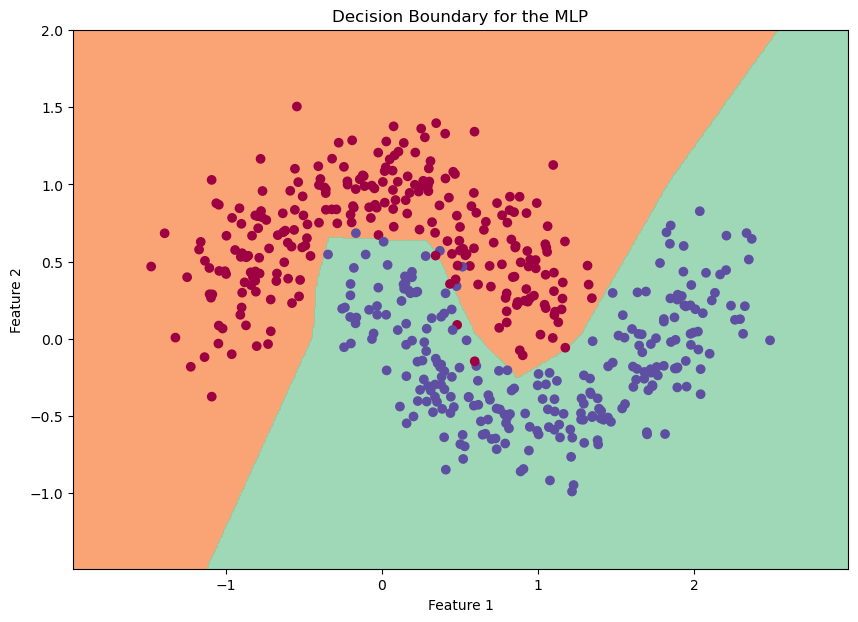

TypeError: MLP.accuracy() missing 2 required positional arguments: 'X' and 'Y'

In [52]:
X, Y = make_moons(n_samples=500, noise=0.2, random_state=42)
X_train = X.T
Y_train = Y.reshape(1, Y.shape[0])

l = MLP(X_train,Y_train)
l.model(2,5,5,1)
l.train(5000,0.1)
l.plot_decision_boundary(X_train, Y_train)

X_val, Y_val = make_moons(n_samples=100, noise=0.4, random_state=42)
X_val = X_val.T
Y_val = Y_val.reshape(1,Y_val.shape[0])
l.X = X_val
l.Y = Y_val
l.accuracy()

